In [1]:
import numpy as np
import torch

In [2]:
K = 7; N = 64; d = 128

In [3]:
z = np.random.randn(N, d)
s = np.random.randn(K, d)
Sigma = np.random.randn(K, d)

In [4]:
(z[None, ...] - s[:, None, :]).shape

(7, 64, 128)

In [5]:
(z[None, ...]/Sigma[:, None, :]).shape

(7, 64, 128)

In [6]:
((z[None, ...] - s[:, None, :]).dot((z[None, ...] - s[:, None, :]).T)).shape

ValueError: shapes (7,64,128) and (128,64,7) not aligned: 128 (dim 2) != 64 (dim 1)

In [7]:
from sklearn import cluster, datasets
import matplotlib.pyplot as plt

n_samples = 1500
varied = datasets.make_blobs(
    n_samples=n_samples,
    centers=3, n_features=2
)

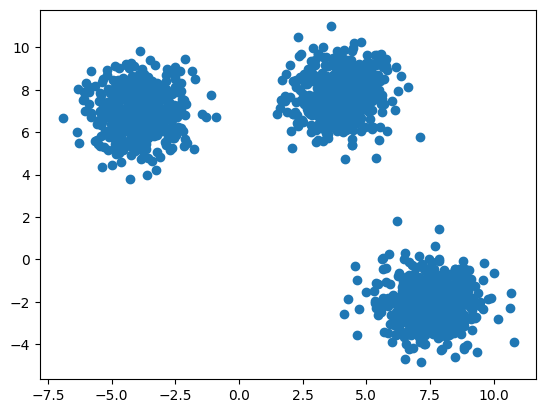

In [8]:
plt.scatter(varied[0][:,0], varied[0][:, 1])
plt.show()

In [9]:
from sklearn.mixture import GaussianMixture

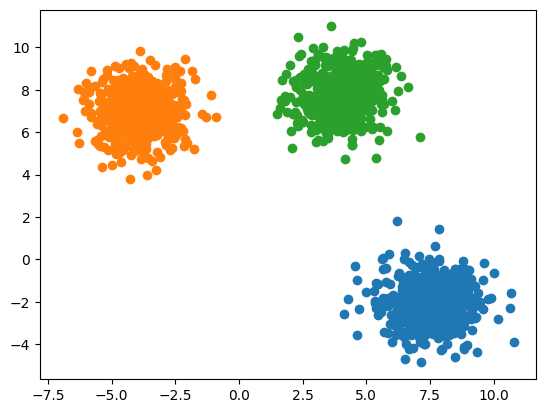

In [10]:
bgm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42).fit(varied[0])
responsibilities = bgm.predict(varied[0])

nc=3
for c in range(nc):
    plt.scatter(varied[0][responsibilities == c ][:,0], 
                    varied[0][responsibilities == c ][:, 1])

plt.show()

In [11]:
A = np.random.randn(8, 6, 32)
B = np.random.randn(8, 6, 32)
np.tensordot(A, B, axes=([0, 2],[0, 2])).shape

(6, 6)

# Different K, V functions

In [12]:
import torch

def seed_all(seed = 2023, deterministic=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_all()

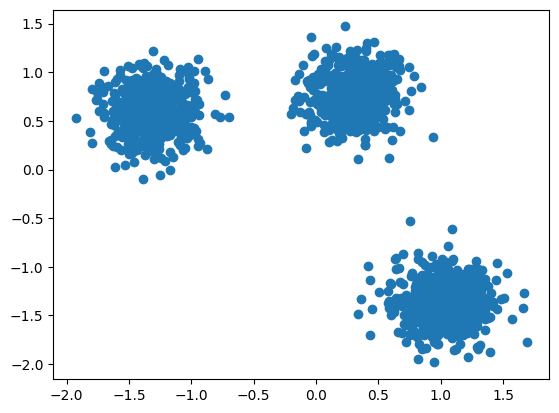

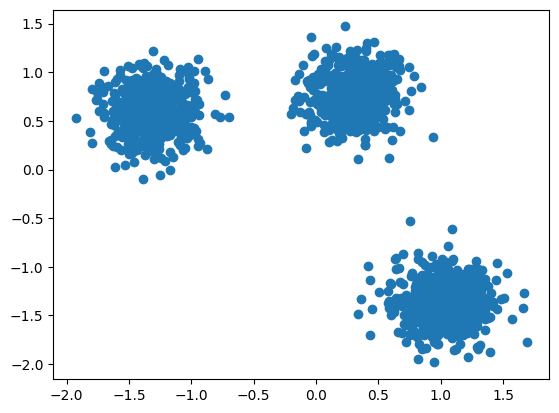

tensor([[[-0.5037, -1.2524],
         [ 0.7017,  2.2875],
         [ 1.2012, -0.9516]]]) tensor([[[1., 1.],
         [1., 1.],
         [1., 1.]]])
torch.Size([1500, 3])
tensor([[1.0000e-08, 1.0000e+00, 1.0000e-08],
        [1.0000e+00, 1.0000e-08, 1.0000e-08],
        [1.0001e-08, 1.0000e+00, 1.0000e-08],
        ...,
        [1.0000e+00, 1.6441e-08, 1.0000e-08],
        [1.0000e+00, 1.0000e-08, 1.0000e-08],
        [1.0000e-08, 1.0000e+00, 1.0000e-08]])
tensor([[[0.3333],
         [0.3333],
         [0.3333]]])


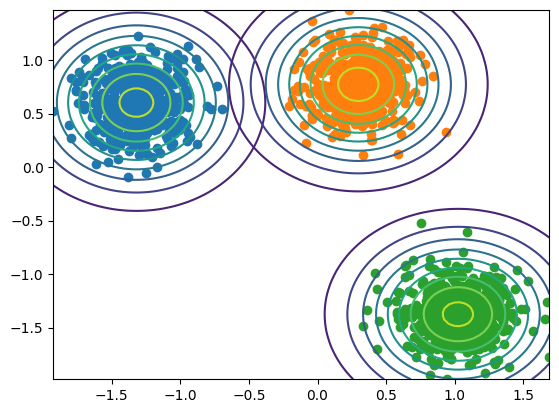

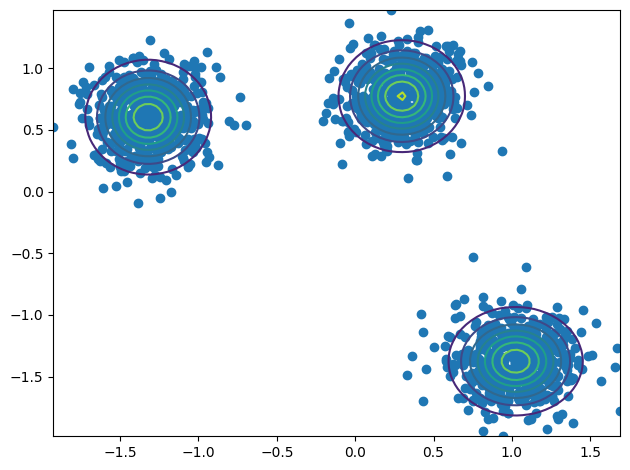

In [16]:
import torch
from torch import Tensor, nn
from typing import Dict, List, Optional, Tuple
from torch.distributions import Normal
 
class GMM:
    """
    Class to implement the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models (GMM) using PyTorch.
 
    Attributes:
    - num_components: int
        Number of components in the GMM.
    - num_features: int
        Number of features in the data.
    - means: torch.Tensor
        Tensor to store the means of the Gaussian components.
    - covariances: torch.Tensor
        Tensor to store the covariance matrices of the Gaussian components.
    - weights: torch.Tensor
        Tensor to store the weights of the Gaussian components.
    """
 
    def __init__(self, num_components: int, num_features: int, MAP: bool = False):
        """
        Constructor to instantiate the GMM class.
 
        Parameters:
        - num_components: int
            Number of components in the GMM.
        - num_features: int
            Number of features in the data.
        """
 
        self.num_components = num_components
        self.num_features = num_features
        self.map = MAP
        self.eps = 1e-8

        self.to_q = nn.Identity()
        self.to_k = nn.Identity()
        self.to_v = nn.Identity()


        min_p = -1; max_p = 1
        # self.to_q = nn.Linear(self.num_features, self.num_features, bias=False)
        # self.to_k = nn.Linear(self.num_features, self.num_features, bias=False)
        # self.to_v = nn.Linear(self.num_features, self.num_features, bias=False)
        # for param in self.to_k.parameters():
        #     nn.init.uniform_(param, 0, 1)
        # nn.init.xavier_uniform_(self.to_k.data.weights, -2, 2)

        self.norm_pre_ff         = nn.LayerNorm(self.num_features)
        self.slot_transformation = nn.Sequential(nn.Linear(self.num_features, self.num_features))

        self.norm_input  = nn.LayerNorm(self.num_features)
        self.norm_slots  = nn.LayerNorm(self.num_features)

        
    def EM_step_MLE(self, 
                     slots_prev: Tensor, 
                     sigma_prev: Tensor, 
                     pi_prev: Tensor, 
                     k: Tensor, 
                     v: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        # E-step
        b, N, d = k.shape
        _, K, _ = slots_prev.shape

        # slots_prev = self.norm_slots(slots_prev)
        q = self.to_q(slots_prev)
                         
        log_pi    = - 0.5 * torch.tensor(2 * torch.pi, device=k.device).log()
        log_scale = - torch.log(torch.clamp(sigma_prev.unsqueeze(2), min = self.eps)) # (B, K, N, d)
        exponent  = - 0.5 * (k.unsqueeze(1) - q.unsqueeze(2)) ** 2 / (sigma_prev.unsqueeze(2)) ** 2 # (B, K, N, d)
        log_probs = torch.log(torch.clamp(pi_prev, min = self.eps)) + (exponent + log_pi + log_scale).sum(dim=-1) # (B, K, N)
                         
        attn = log_probs.softmax(dim=1) + self.eps # (B, K, N)


                         
        # M-step
        Nk = torch.sum(attn, dim=2, keepdim=True) # (B, K, 1)
        pi = Nk / N

        print(pi)
        slots = (1 / Nk) * torch.sum(attn.unsqueeze(-1) * v.unsqueeze(1), dim=2) # (B, K, D)

        sigma = (1 / Nk) * torch.sum(attn.unsqueeze(-1) * (v.unsqueeze(1) - slots.unsqueeze(2))**2, dim=2) # (B, K, D)
        sigma = torch.sqrt(sigma) + self.eps

        # slots = slots + self.slot_transformation(slots)
        return slots, pi, sigma, attn

    def EM_step_MAP(self, 
                 slots_prev: Tensor, 
                 sigma_prev: Tensor, 
                 sigma_initial: Tensor,
                 pi_prev: Tensor, 
                 k: Tensor, 
                 v: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        # E-step
        b, N, d = k.shape
        _, K, _ = slots_prev.shape
    
        # slots_prev = self.norm_slots(slots_prev)
        q = self.to_q(slots_prev)
                         
        log_pi    = - 0.5 * torch.tensor(2 * torch.pi, device=k.device).log()
        log_scale = - torch.log(torch.clamp(sigma_prev.unsqueeze(2), min = self.eps)) # (B, K, N, d)
        exponent  = - 0.5 * (k.unsqueeze(1) - q.unsqueeze(2)) ** 2 / (sigma_prev.unsqueeze(2)) ** 2 # (B, K, N, d)
        log_probs = torch.log(torch.clamp(pi_prev, min = self.eps)) + (exponent + log_pi + log_scale).sum(dim=-1) # (B, K, N)
                         
        attn = log_probs.softmax(dim=1) + self.eps # (B, K, N)
    
                         
        # M-step
        # Update prior parameters
        Nk = torch.sum(attn, dim=2, keepdim=True)  # (B, K, 1)
    
        # Update means with MAP estimate
        slots = (1 / Nk) * torch.sum(attn.unsqueeze(-1) * v.unsqueeze(1), dim=2) # (B, K, D)
    
        # Update covariances with MAP estimate
        sigma = (sigma_initial + torch.sum(attn.unsqueeze(-1) * (v.unsqueeze(1) - slots_prev.unsqueeze(2)) ** 2, dim=2)) / (Nk + 2*d + 4)  # (B, K, D)
        sigma = torch.sqrt(sigma) + self.eps
    
        # Update weights with MAP estimate
        pi = Nk / N

        return slots, pi, sigma, attn

                         
    def SA_step(self, slots_prev: Tensor, 
                    k: Tensor, 
                    v: Tensor) -> Tuple[Tensor, Tensor]:

        q = self.to_q(slots_prev)

        dots = torch.einsum('bid, bjd -> bij', q, k) * (self.num_features ** 0.5)
        attn_vis = dots.softmax(dim=1) + self.eps
        attn = attn_vis / attn_vis.sum(dim=-1, keepdim=True)

        slots = torch.einsum('bjd,bij->bid', v, attn)

        return slots, _, _, attn_vis


    def capsule_step(self, slots_prev: Tensor, 
                     pi: Tensor,
                     votes: Tensor, 
                     agreement: Tensor) -> Tuple[Tensor, Tensor]:
                         
        b, K, N, d = votes.shape
                         
        def _squash_(x: Tensor, dim: int = -1) -> Tensor:
            squared_norm = torch.sum(x**2, dim=dim, keepdim=True)
            norm = torch.sqrt(squared_norm + 1e-8)
            new_magnitude = squared_norm / (1.0 + squared_norm)
            unit_vec = x / norm
            return new_magnitude * unit_vec

        # (b, k, n)
        agreement += torch.einsum("bkd,bknd->bkn", slots_prev, votes)
        attn = agreement.softmax(dim=1) + self.eps
        
        # (b, k, d)  
        slots = torch.einsum("bkn,bknd->bkd", attn, votes)
        slots = _squash_(slots, dim=-1)

                        
        return slots, pi, _, attn, agreement

                        
    def fit(self, data: torch.Tensor, num_iterations: int):
        """
        Fits the GMM to the given data using the EM algorithm.
 
        Parameters:
        - data: torch.Tensor
            Tensor containing the data points.
        - num_iterations: int
            Number of iterations to run the EM algorithm.
 
        Returns:
        - torch.Tensor:
            Tensor containing the responsibilities for each data point and component after the final iteration.
        """
        # data = (data - data.min(0, keepdim=True)[0])/(data.max(0, keepdim=True)[0] - data.min(0, keepdim=True)[0] + self.eps)
        # data = data/data.max(0, keepdim=True)[0]
        data = (data - data.mean(0, keepdim=True))/data.std(0, keepdim=True)

        data = data.unsqueeze(0).type(torch.float32) # 1 x N x d
        
        k = self.to_k(data)
        v = self.to_v(data)

        votes = data.unsqueeze(1).repeat(1, self.num_components, 1, 1) # 1 x K x N x d 
        agreement = torch.zeros(data.shape[0], self.num_components, votes.shape[2])
        
        k_numpy = k.squeeze(0).detach().cpu().numpy()
        plt.clf()
        plt.scatter(k_numpy[:,0], k_numpy[:, 1])
        plt.show()
        
        v_numpy = v.squeeze(0).detach().cpu().numpy()
        plt.clf()
        plt.scatter(v_numpy[:,0], v_numpy[:, 1])
        plt.show()
        
        # Initialize the means, covariances, and weights randomly
        # mean = np.array([[-9.5, -6.0], [-3.5, 0], [2.5, 0]])
        # slots = torch.from_numpy(mean).type(torch.float32).unsqueeze(0)
        slots = torch.randn(data.shape[0],self.num_components, self.num_features)
        sigma = torch.ones(data.shape[0],self.num_components, self.num_features)
        pi = torch.ones(data.shape[0], self.num_components, 1)/self.num_components

        
        sigma_initial = torch.var(data, dim=1, keepdim=True) # B, 1, d
        sigma_initial /= (self.num_components**(1/d))
    
        
        print (slots, sigma)
        for _ in range(num_iterations):
            # slots, pi, sigma, attn = self.SA_step(slots, k, v)
            # slots, pi, sigma, attn = self.EM_step_MLE(slots, sigma, pi, k, v)
            slots, pi, sigma, attn = self.EM_step_MAP(slots, sigma, sigma_initial, pi, k, v)
            # slots, pi, sigma, attn, agreement = self.capsule_step(slots, pi, votes, agreement)
 
        return data[0].detach().cpu().numpy(), attn.squeeze().t(), slots, sigma, pi
 
# Example usage of the GMM class:
 
# Initialize the GMM with 2 components and 2 features
gmm = GMM(num_components=3, num_features=2)
 
# Fit the GMM to the data using the EM algorithm for 10 iterations
data, responsibilities, slots, sigma, pi = gmm.fit(torch.from_numpy(varied[0]), num_iterations=100)
 
# Print the responsibilities for the data points after the final iteration
print(responsibilities.shape)
print(responsibilities)
print(pi)

plt.clf()
nc = responsibilities.shape[-1]
responsibilities = responsibilities.argmax(1).numpy()




# from scipy.stats import multivariate_normal

# for c in range(gmm.num_components):
#     mean = slots[0, c].detach().numpy()
#     cov = 0.01*np.eye(mean.shape[0])
#     rv = multivariate_normal(mean, cov)
#     plt.scatter(data[responsibilities == c ][:,0], 
#                     data[responsibilities == c ][:, 1])

#     x, y = np.meshgrid(np.linspace(data[:, 0].min(), data[:, 0].max(), 100),
#                        np.linspace(data[:, 1].min(), data[:, 1].max(), 100))
#     xy = np.column_stack((x.ravel(), y.ravel()))
#     z = rv.pdf(xy).reshape(x.shape)
#     plt.contour(x, y, z, levels=10)

# plt.show()




from scipy.stats import multivariate_normal

for c in range(gmm.num_components):
    mean = slots[0, c].detach().numpy()
    cov = np.diag(sigma[0, c].detach().numpy())
    rv = multivariate_normal(mean, cov)
    plt.scatter(data[responsibilities == c ][:,0], 
                    data[responsibilities == c ][:, 1])

    x, y = np.meshgrid(np.linspace(data[:, 0].min(), data[:, 0].max(), 100),
                       np.linspace(data[:, 1].min(), data[:, 1].max(), 100))
    xy = np.column_stack((x.ravel(), y.ravel()))
    z = rv.pdf(xy).reshape(x.shape)
    plt.contour(x, y, z, levels=10)

plt.show()



def gaussian_log_prob(x, loc, scale):
    return (
        -0.5 * torch.tensor(2 * torch.pi, device=x.device).log()
        - torch.log(scale)
        - 0.5 * (x - loc) ** 2 / scale ** 2
    )


plt.clf()
plt.scatter(data[:,0], data[:, 1])
coord = np.array([x.ravel(), y.ravel()]).T
coord = torch.from_numpy(coord).unsqueeze(1)
log_probs = torch.log(pi) + gaussian_log_prob(coord, slots, sigma).sum(dim=-1, keepdim=True)
likelihood = log_probs.exp().sum(dim=1).reshape(x.shape)
# log_likelihood = log_probs.logsumexp(dim=1).reshape(x_grid.shape)
plt.contour(x, y, likelihood, levels=10)
plt.tight_layout()


plt.show()

In [563]:
slots[0, c].shape

torch.Size([2])